In [1]:
using CairoMakie
using StaticArrays
using Distributions
using ProgressMeter
using MakiePublication

function rhs(u, p, t)
     return u
end


function simulate(u0, T, dt, p; f = rhs)
    t = 0.0
    
    u = copy(u0)
    
    while t < T
        u = u + dt * f(u, p , t)
         
        t += dt
    end
    
    return u
end


function make_ensemble(M, dt)
   ensemble = zeros(M)
    
    for m in 1:M
       ensemble[m] = simulate(rand(Uniform(1, 2)), 1.0, dt, [])
    end
    
    ensemble
end

function make_ensemble_pair(M, dt1, dt2)
   ensemble = zeros((2, M))
    
    for m in 1:M
        u0 = rand(Uniform(1, 2))
        ensemble[1, m] = simulate(u0, 1.0, dt1, [])
        ensemble[2, m] = simulate(u0, 1.0, dt2, [])
    end
    
    ensemble
end


LoadError: ArgumentError: Package CairoMakie not found in current path:
- Run `import Pkg; Pkg.add("CairoMakie")` to install the CairoMakie package.


In [2]:
ensemble = make_ensemble(1000000, 0.01);

In [3]:
mean(ensemble)

4.0559442653639195

In [4]:
var(ensemble)

0.6096484585664307

In [5]:
actualvar = 1/3 * (exp(1)^2*2^3-exp(1)^2) - (1/2 * (exp(1)*2^2-exp(1)))^2


0.6157546749108818

In [6]:
actualmean = 1/2 * (exp(1)*2^2-exp(1))

4.077422742688568

In [7]:
function make_mlmc_ensemble(dts, samples)
    ensemble = []
    push!(ensemble, make_ensemble(samples[1], dts[1]))
    for (n, (dtcoarse, dtfine, M)) in enumerate(zip(dts[1:end-1], dts[2:end], samples[2:end]))
        push!(ensemble, make_ensemble_pair(M, dtfine, dtcoarse))
    end
    return ensemble
end

make_mlmc_ensemble (generic function with 1 method)

In [25]:
function estimate_mlmc_mean(g, ensemble)
    m = mean(g.(ensemble[1]))
    for level in ensemble[2:end]
        m += mean(g.(level[1, 1:end])) - mean(g.(level[2, 1:end]))
    end
    return m
end

function estimate_mlmc_var_alt(ensemble)
    m = mean((ensemble[1] .- mean(ensemble[1])).^2)
    for level in ensemble[2:end]
        m += mean((level[1, 1:end] .- mean(level[1, 1:end])).^2) - mean((level[2, 1:end] .- mean(level[2, 1:end])).^2)
    end
    return m
end

function estimate_mlmc_var(ensemble)
   return estimate_mlmc_mean(x->x.^2, ensemble) -  estimate_mlmc_mean(x->x, ensemble)^2
end

estimate_mlmc_var (generic function with 1 method)

In [9]:
startres = 2
endres = 10
dts = 1.0 ./ (2 .^ (startres:endres))
samples = reverse(16 * 4 .^( ((startres:endres) .- startres)))

9-element Vector{Int64}:
 1048576
  262144
   65536
   16384
    4096
    1024
     256
      64
      16

In [10]:
mlmc_ensemble = make_mlmc_ensemble(dts, samples);

In [11]:
m = estimate_mlmc_mean(x->x, mlmc_ensemble)

4.0763778155797175

In [12]:
estimate_mlmc_mean(x->x^2, mlmc_ensemble)-estimate_mlmc_mean(x->x, mlmc_ensemble)^2

0.6184585507158964

In [13]:
estimate_mlmc_mean(x->(x-m)^2, mlmc_ensemble)

0.618458550715878

In [14]:
(startres:endres) .- startres

0:8

In [15]:
estimate_mlmc_var_alt(mlmc_ensemble)

0.6160134366982297

In [16]:
repeats = 50
observations = Dict("Plain" => [], "Alt" => [])
for repeat in 1:repeats
    mlmc_ensemble = make_mlmc_ensemble(dts, samples);
    
    push!(observations["Alt"], estimate_mlmc_var_alt(mlmc_ensemble))
    push!(observations["Plain"], estimate_mlmc_mean(x->x^2, mlmc_ensemble)-estimate_mlmc_mean(x->x, mlmc_ensemble)^2)
end

In [17]:
@show mean(observations["Alt"] .- actualvar)
@show mean(observations["Plain"] .- actualvar)

mean(observations["Alt"] .- actualvar) = -0.0006492765273692913
mean(observations["Plain"] .- actualvar) = -0.00034693788586700694


-0.00034693788586700694

In [31]:
errors = Dict("Plain" => Float64[], "Alt" => Float64[], "Precomputed" => Float64[])
@showprogress for end_resolution in 5:10
    repeats = 50
    observations = Dict("Plain" => [], "Alt" => [], "Precomputed" => Float64[])
    dts = 1.0 ./ (2 .^ (startres:end_resolution))
    samples = reverse(16 * 4 .^( ((startres:end_resolution) .- startres)))
    for repeat in 1:repeats
        mlmc_ensemble = make_mlmc_ensemble(dts, samples);

        push!(observations["Alt"], estimate_mlmc_var_alt(mlmc_ensemble))
        push!(observations["Plain"], estimate_mlmc_var(mlmc_ensemble))
        
        m = estimate_mlmc_mean(x->x, mlmc_ensemble)
        push!(observations["Precomputed"], estimate_mlmc_mean(x->(x.-m).^2, mlmc_ensemble))

    end
    for (k, v) in observations
        push!(errors[k], mean(abs.(v .- actualvar)))
    end 
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


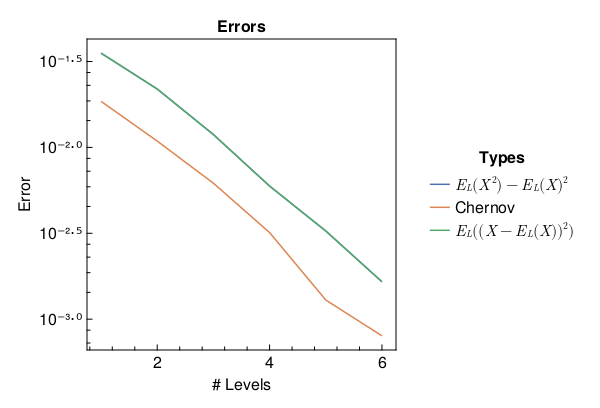

In [40]:
correctlabels = Dict("Plain" => L"E_L(X^2)-E_L(X)^2", "Alt" => "Chernov", "Precomputed" => L"E_L((X-E_L(X))^2)")
MakiePublication.with_theme(MakiePublication.theme_web()) do
    f = CairoMakie.Figure()
    ax = CairoMakie.Axis(f[1, 1], title="Errors", yscale = log10, xlabel="# Levels", ylabel="Error")
    for (k, v) in errors
        CairoMakie.lines!(ax, v, label=correctlabels[k])
    end
    f[1, 2] = Legend(f, ax, "Types", framevisible = false)    
    return f
end

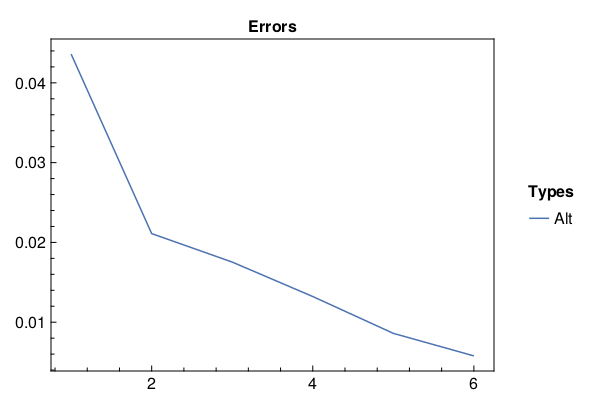

In [28]:
MakiePublication.with_theme(MakiePublication.theme_web()) do
    f = CairoMakie.Figure()
    ax = CairoMakie.Axis(f[1, 1], title="Errors")
    CairoMakie.lines!(ax, errors["Alt"], label="Alt")
    f[1, 2] = Legend(f, ax, "Types", framevisible = false)    
    return f
end

In [29]:

errorsmean = Dict("Plain" => Float64[])
@showprogress for end_resolution in 5:14
    repeats = 50
    observations = Dict("Plain" => [])
    dts = 1.0 ./ (2 .^ (startres:end_resolution))
    samples = reverse(16 * 4 .^( ((startres:end_resolution) .- startres)))
    for repeat in 1:repeats
        mlmc_ensemble = make_mlmc_ensemble(dts, samples);

        push!(observations["Plain"], estimate_mlmc_mean(x->x, mlmc_ensemble))
        
    end
    for (k, v) in observations
        push!(errorsmean[k], mean(abs.(v .- actualmean)))
    end 
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:03


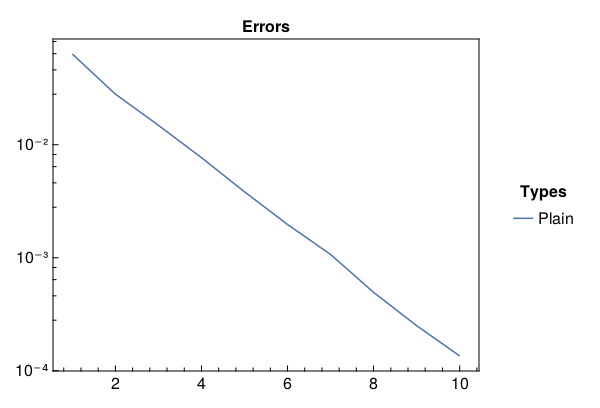

In [30]:
MakiePublication.with_theme(MakiePublication.theme_web()) do
    f = CairoMakie.Figure()
    ax = CairoMakie.Axis(f[1, 1], title="Errors", yscale = log10)
    for (k, v) in errorsmean
        CairoMakie.lines!(ax, v, label=k)
    end
    f[1, 2] = Legend(f, ax, "Types", framevisible = false)    
    return f
end